In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from methods.model_fitting_utilities import softmax_neg_log_likelihood
from scipy import stats
from scipy.optimize import minimize

from scipy.spatial.distance import pdist

def calc_accuracy(ground_truth_str, MAP_str):
    ground_truth = np.array(" ".join(ground_truth_str[1:-1].split(' ')).split(), dtype=float)
    MAP = np.array(" ".join(MAP_str[1:-1].split(' ')).split(), dtype=float)

    acc = 1-pdist(np.stack((ground_truth, MAP)))[0] / np.linalg.norm(abs(np.array(ground_truth)) + 2*np.ones((1, 6)))

    return acc

In [83]:
models_labels = {
    'LC_discrete_attention_&_att': 'LC w. attention',
    'LC_discrete_attention_&_att_prior': 'LC w. attention w. prior',
    'LC_discrete_att_&_att': 'AS LC',
    'LC_discrete_att_&_att_prior': 'AS LC w. prior',
    'normative_&_1': 'Normative',
    'normative_&_prior': 'Normative w. prior',
    'LC_discrete_&_1': 'LC basic',
    'LC_discrete_&_prior': 'LC basic w. prior',
    'change_d_obs_fk_&_att_cha_prior': 'Change w. full knowledge w. prior',
    'change_d_obs_fk_&_att_cha': 'Change w. full knowledge',
    'change_obs_fk_&_att_cha_prior': 'Change w. prior',
    'change_obs_fk_&_att_cha': 'Change',
    'ces_strength_&_str_guess': 'CEA strength sensitive',
    'ces_no_strength_&_guess': 'CEA basic'
}

color_dict = {
    'Participants': tuple(sns.color_palette("icefire")[2]),
    'LC w. attention': tuple(sns.light_palette("seagreen")[-1]), 
    'LC w. attention w. prior': tuple(sns.light_palette("seagreen")[-2]),
    'AS LC': tuple(sns.light_palette("seagreen")[-1]), 
    'AS LC w. prior': tuple(sns.light_palette("seagreen")[-2]),
    'Change w. full knowledge': tuple(sns.color_palette("mako")[1]), 
    'Change w. full knowledge w. prior': tuple(sns.color_palette("mako")[2]),
    'Change': tuple(sns.color_palette("mako")[1]), 
    'Change w. prior': tuple(sns.color_palette("mako")[2]),
    'Change linear cause effect': tuple(sns.color_palette("mako")[3]),
    'Change linear cause': tuple(sns.color_palette("mako")[4]),
    'LC basic': tuple(sns.color_palette("Paired")[5]),
    'LC basic w. prior': tuple(sns.color_palette("Paired")[4]),
    'Normative': tuple(sns.color_palette("Set2")[-3]), 
    'Normative w. prior': tuple(sns.color_palette("Paired")[-2]),
    'CEA strength sensitive': tuple(sns.color_palette("YlOrBr")[4]),
    'CEA basic': tuple(sns.color_palette("YlOrBr")[3]),
    'Baseline': tuple(sns.color_palette("Set2")[-1]),
    'att_OA': tuple(sns.light_palette("seagreen")[-1]),
    'LC_OA': tuple(sns.color_palette("Paired")[5]),
    'att_TA': tuple(sns.light_palette("seagreen")[-1]),
    'LC_TA': tuple(sns.color_palette("Paired")[5])
}

## Dictionary for color allocation
def gen_colors(labels, color_dict):
    return [color_dict[label] for label in labels]

# Local computation accuracy comparisons

In [119]:
lc_OA_raw = pd.read_csv('./data/model_fitting_outputs/summary_data_run_OA_LC_discrete_&_1.csv')
att_OA_raw = pd.read_csv('./data/model_fitting_outputs/summary_data_run_OA_LC_discrete_att_&_att.csv')

lc_OA_raw['accuracy'] = lc_OA_raw.apply(lambda x: calc_accuracy(x.ground_truth, x.posterior_map), axis=1)
att_OA_raw['accuracy'] = att_OA_raw.apply(lambda x: calc_accuracy(x.ground_truth, x.posterior_map), axis=1)

participants = lc_OA_raw.copy()
participants['accuracy'] = participants.apply(lambda x: calc_accuracy(x.ground_truth, x.posterior_judgement), axis=1)
participants['model_name'] = 'Participants'

print(lc_OA_raw.shape)
print(att_OA_raw.shape)

att_OA_raw.model_name.value_counts()

(1784, 15)
(1784, 15)


LC_discrete_att_&_att    1784
Name: model_name, dtype: int64

In [117]:
full_summary_TA_raw_all_models = pd.read_csv('./data/model_fitting_outputs/summary_data_fit_true.csv')
full_summary_TA_raw = full_summary_TA_raw_all_models[full_summary_TA_raw_all_models.model_name.isin(['LC_discrete_att_&_att', 'LC_discrete_&_1'])]

full_summary_TA_raw['accuracy'] = full_summary_TA_raw.apply(lambda x: calc_accuracy(x.ground_truth, x.posterior_map), axis=1)


/tmp/ipykernel_928/1209623653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_summary_TA_raw['accuracy'] = full_summary_TA_raw.apply(lambda x: calc_accuracy(x.ground_truth, x.posterior_map), axis=1)


In [118]:
print(lc_OA_raw.accuracy.mean())
print(att_OA_raw.accuracy.mean())
print(full_summary_TA_raw[full_summary_TA_raw.model_name == 'LC_discrete_&_1'].accuracy.mean())
print(full_summary_TA_raw[full_summary_TA_raw.model_name == 'LC_discrete_att_&_att'].accuracy.mean())

0.9348475017783826
0.9077455700277203
0.8776059372707723
0.879069154058802


In [136]:
lc_OA_raw['tag'] = 'OA'
att_OA_raw['tag'] = 'OA'
full_summary_TA_raw.loc[full_summary_TA_raw.model_name == 'LC_discrete_&_1', 'tag'] = 'TA' 
full_summary_TA_raw.loc[full_summary_TA_raw.model_name == 'LC_discrete_att_&_att', 'tag'] = 'TA'

participants['tag'] = 'OA'
participants_2 = participants.copy()
participants_2['tag'] = 'TA'
df = pd.concat([
    lc_OA_raw, 
    att_OA_raw, 
    full_summary_TA_raw, 
    #participants, 
    #participants_2
])

def rename_graphs(name):
    if name[0:3] in ['pos', 'neg']:
        return name.split('_')[1]
    else:
        return name

df['graph_family'] = df.apply(lambda x: rename_graphs(x.scenario), axis=1)
participants['graph_family'] = participants.apply(lambda x: rename_graphs(x.scenario), axis=1)
df['Model Name'] = df.model_name.replace(models_labels)

/home/vbtesh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Reclassify graph structures

In [133]:
print(df.columns)

Index(['utid', 'pid', 'experiment', 'difficulty', 'scenario', 'model_name',
       'ground_truth', 'posterior_map', 'posterior_judgement',
       'prior_judgement', 'prior_entropy', 'posterior_entropy_unsmoothed',
       'posterior_entropy', 'model_specs', 'accuracy', 'tag', 'graph_family',
       'Model Name'],
      dtype='object')


In [134]:
df.scenario.value_counts()

crime            1566
finance          1434
dampened          950
ccause            708
collider          708
pos_chain         598
estate            484
neg_chain         344
pos_confound      168
crime_control     104
neg_confound       96
Name: scenario, dtype: int64

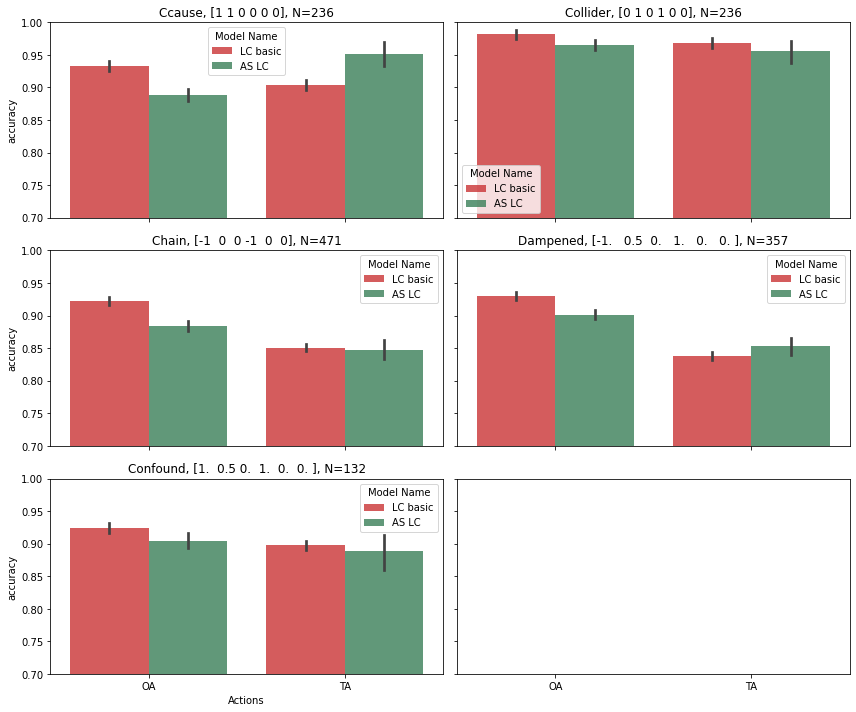

In [148]:
generic_graphs = [
    'ccause', 
    'collider', 
    'chain', 
    'dampened', 
    'confound', 
    #'crime_control',
    #'crime',
    #'finance'
]

nrows = len(generic_graphs) // 2 if len(generic_graphs) % 2 == 0 else len(generic_graphs) // 2 + 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10), sharex=True, sharey=True)

row = 0
col = 0
for i, graph in enumerate(generic_graphs):
    hue = 'Model Name'
    x = 'tag'
    y = 'accuracy'
    
    df_plot = df[df.graph_family == graph]
    #df_plot.model_name.replace(models_labels, inplace=True)
    #print(graph)
    #print(df_plot.shape)

    colors = gen_colors(df_plot["Model Name"].unique(), color_dict)
    sns.set_palette(colors)
    
    #print(colors)
    #sns.barplot(x='model_name', y='accuracy', data=participants[participants.graph_family == graph], ax=axs[row, col])

    sns.barplot(x=x, y=y, hue=hue, data=df_plot, ax=axs[row, col], alpha=0.8)

    #sns.barplot(x='model_name', y='accuracy', data=participants[participants.graph_family == graph], ax=axs[row, col], linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

    
    axs[row, col].set_ylim([0.7, 1])
    
    axs[row, col].set_title(f'{graph.capitalize()}, {df_plot.ground_truth.tolist()[0]}, N={df_plot.utid.unique().size}')

    if row < nrows - 1:
        axs[row, col].set_xlabel('')
    else:
        axs[row, col].set_xlabel('Actions')

    if col == 1:
        axs[row, col].set_ylabel('')
        row += 1
        col = 0
    else:
        col += 1


plt.tight_layout()
plt.show()


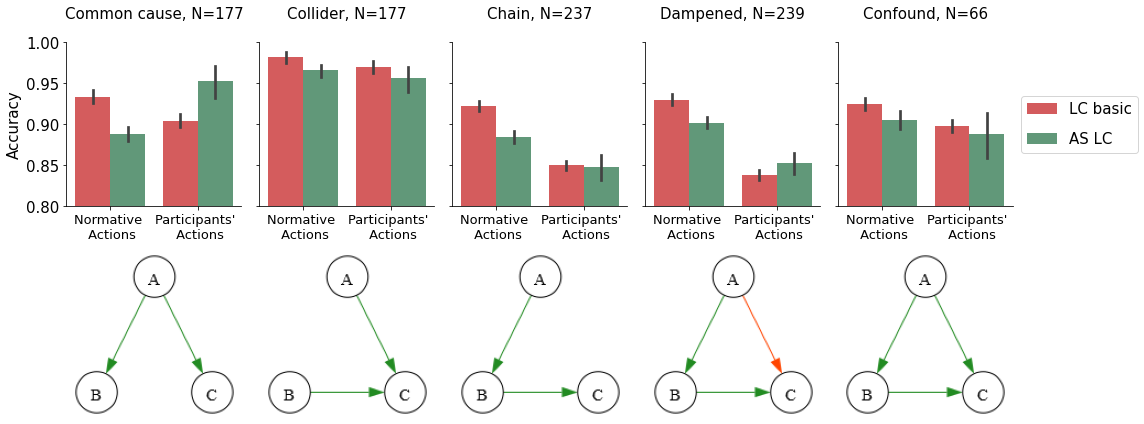

In [253]:
generic_graphs = [
    'ccause', 
    'collider', 
    'chain', 
    'dampened', 
    'confound', 
    #'crime_control',
    #'crime',
    #'finance'
]

model_counts = {
    'ccause': 177,
    'chain': 237,
    'collider': 177,
    'confound': 66,
    'crime': 394,
    'crime_control': 26,
    'dampened': 239,
    'estate': 121,
    'finance': 360
}

nrows = 2
ncols = len(generic_graphs)
ylim = np.array([0.8, 1])
yticks = np.linspace(ylim[0], ylim[1], 5).round(2)

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6))

for i, graph in enumerate(generic_graphs):
    hue = 'Model Name'
    x = 'tag'
    y = 'accuracy'
    
    df_plot = df[df.graph_family == graph]
    N = model_counts[graph]
    #df_plot.model_name.replace(models_labels, inplace=True)
    #print(graph)
    #print(df_plot.shape)

    colors = gen_colors(df_plot["Model Name"].unique(), color_dict)
    sns.set_palette(colors)
    
    #print(colors)
    #sns.barplot(x='model_name', y='accuracy', data=participants[participants.graph_family == graph], ax=axs[row, col])

    sns.barplot(x=x, y=y, hue=hue, data=df_plot, ax=axs[0, i], alpha=0.8)

    #sns.barplot(x='model_name', y='accuracy', data=participants[participants.graph_family == graph], ax=axs[row, col], linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

    
    axs[0, i].set_ylim(*ylim)

    title = 'common Cause' if graph == 'ccause' else graph
    
    axs[0, i].set_title(f'{title.capitalize()}, N={N}\n', fontsize=15)# \n{df_plot.ground_truth.tolist()[0]}', fontsize=15)
    
    handles, labels = axs[0, i].get_legend_handles_labels()

    if i < ncols - 1:
        axs[0, i].legend([], [], frameon=False)
    else:
        axs[0, i].legend(handles[0:2], labels[0:2], labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5), fontsize=15)
        
    axs[0, i].set_yticks(yticks)
    plt.setp(axs[0, i].get_yticklabels(), fontsize=15)
    if i == 0:
        axs[0, i].set_ylabel(axs[0, i].get_ylabel().capitalize(), fontsize=15)        
    else:  
        axs[0, i].set_ylabel('')
        axs[0, i].set_yticklabels([])

    sns.despine()

    axs[0, i].set_xticklabels(axs[0, i].get_xticklabels(), fontsize=15)
    axs[0, i].set_xticklabels(["Normative \n Actions", "Participants' \n Actions"], fontsize=13)

    axs[0, i].set_xlabel('')



for i, graph in enumerate(generic_graphs):

    path = '/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/plots/'

    img = mpimg.imread(f'{path}{graph}.png')
    axs[1, i].imshow(img)
    #os.remove('temporary.png')
    axs[1, i].axis('off')
    


plt.tight_layout()
plt.show()

1432


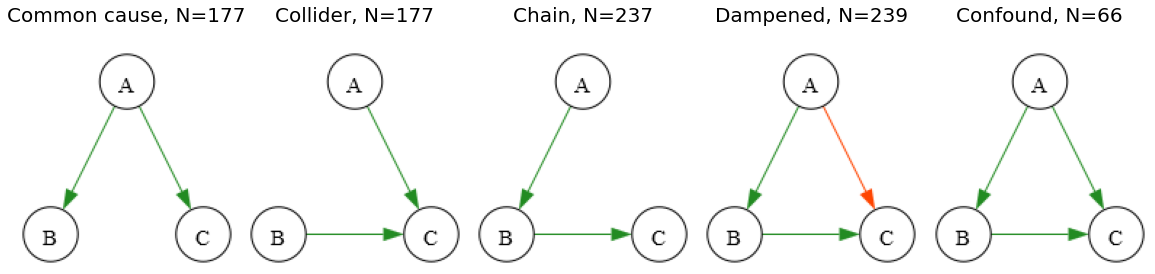

In [256]:
nrows = 1
ncols = len(generic_graphs)
ylim = np.array([0.8, 1])
yticks = np.linspace(ylim[0], ylim[1], 5).round(2)

model_counts = {
    'ccause': 177,
    'chain': 237,
    'collider': 177,
    'confound': 66,
    'crime': 394,
    'crime_control': 26,
    'dampened': 239,
    'estate': 121,
    'finance': 360
}

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6))
total = 0
for i, graph in enumerate(generic_graphs):
    df_plot = df[df.graph_family == graph]

    N = model_counts[graph]
    title = 'common Cause' if graph == 'ccause' else graph
    
    axs[i].set_title(f'{title.capitalize()}, N={N}\n', fontsize=20)# \n{df_plot.ground_truth.tolist()[0]}', fontsize=15)
    

    path = '/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/plots/'

    img = mpimg.imread(f'{path}{graph}.png')
    axs[i].imshow(img)
    #os.remove('temporary.png')
    axs[i].axis('off')

    total += df_plot.utid.unique().size
    
print(total)
plt.tight_layout()
plt.show()

In [230]:
df.columns

Index(['utid', 'pid', 'experiment', 'difficulty', 'scenario', 'model_name',
       'ground_truth', 'posterior_map', 'posterior_judgement',
       'prior_judgement', 'prior_entropy', 'posterior_entropy_unsmoothed',
       'posterior_entropy', 'model_specs', 'accuracy', 'tag', 'graph_family',
       'Model Name'],
      dtype='object')

In [248]:
pids = df.pid.unique()

pids_over = []
pids_under = []
for pid in pids:
    df_pid = df[df.pid == pid]
    if df_pid.utid.unique().size >= 2:
        pids_over.append(pid)

print(len(pids_over))
df[df.pid.isin(pids_over)].experiment.unique()

420


array(['experiment_3', 'experiment_4', 'experiment_1', 'experiment_2'],
      dtype=object)

In [252]:
trials

NameError: name 'trials' is not defined

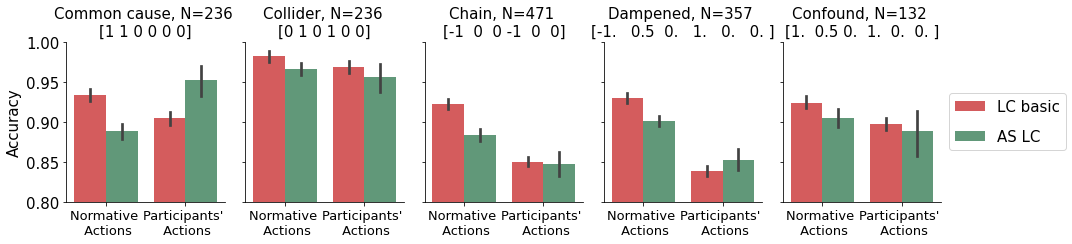

In [191]:
generic_graphs = [
    'ccause', 
    'collider', 
    'chain', 
    'dampened', 
    'confound', 
    #'crime_control',
    #'crime',
    #'finance'
]

nrows = 2
ncols = len(generic_graphs)
ylim = np.array([0.8, 1])
yticks = np.linspace(ylim[0], ylim[1], 5).round(2)

fig, axs = plt.subplots(1, ncols, figsize=(15, 3.5), sharex=True, sharey=True)

for i, graph in enumerate(generic_graphs):
    hue = 'Model Name'
    x = 'tag'
    y = 'accuracy'
    
    df_plot = df[df.graph_family == graph]
    #df_plot.model_name.replace(models_labels, inplace=True)
    #print(graph)
    #print(df_plot.shape)

    colors = gen_colors(df_plot["Model Name"].unique(), color_dict)
    sns.set_palette(colors)
    
    #print(colors)
    #sns.barplot(x='model_name', y='accuracy', data=participants[participants.graph_family == graph], ax=axs[row, col])

    sns.barplot(x=x, y=y, hue=hue, data=df_plot, ax=axs[i], alpha=0.8)

    #sns.barplot(x='model_name', y='accuracy', data=participants[participants.graph_family == graph], ax=axs[row, col], linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

    
    axs[i].set_ylim(*ylim)

    title = 'common Cause' if graph == 'ccause' else graph
    
    axs[i].set_title(f'{title.capitalize()}, N={df_plot.utid.unique().size} \n{df_plot.ground_truth.tolist()[0]}', fontsize=15)
    
    handles, labels = axs[i].get_legend_handles_labels()

    if i < ncols - 1:
        axs[i].legend([], [], frameon=False)
    else:
        axs[i].legend(handles[0:2], labels[0:2], labelspacing=1, loc=6, bbox_to_anchor=(1, 0.5), fontsize=15)
        

    if i == 0:
        axs[i].set_ylabel(axs[i].get_ylabel().capitalize(), fontsize=15)
        axs[i].set_yticks(yticks)
        plt.setp(axs[i].get_yticklabels(), fontsize=15)
        
    else:
        axs[i].set_ylabel('')

    sns.despine()

    axs[i].set_xticklabels(axs[i].get_xticklabels(), fontsize=15)
    axs[i].set_xticklabels(["Normative \n Actions", "Participants' \n Actions"], fontsize=13)

    axs[i].set_xlabel('')




plt.tight_layout()
plt.show()


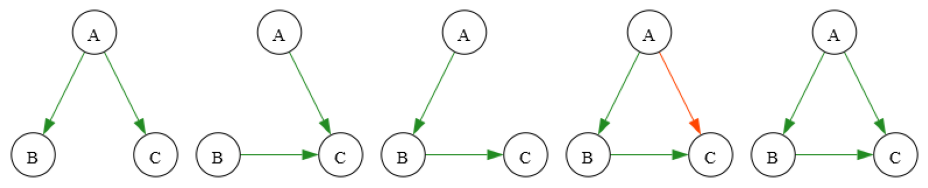

In [194]:
fig, axs = plt.subplots(1, ncols, figsize=(13, 3.5), sharex=True, sharey=True)


for i, graph in enumerate(generic_graphs):

    path = '/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/plots/'

    img = mpimg.imread(f'{path}{graph}.png')
    axs[ i].imshow(img)
    #os.remove('temporary.png')
    axs[i].axis('off')
    


plt.tight_layout()
plt.show()

# Entropy comparisons between models

In [34]:
summary_ta = pd.read_csv('./data/model_fitting_outputs/summary_data_fit_true.csv')
summary_ta['tag'] = 'TA'
summary_sa = pd.read_csv('./data/model_fitting_outputs/summary_data_run_inters_sparse.csv')
summary_sa['tag'] = 'SA'
summary_ca = pd.read_csv('./data/model_fitting_outputs/summary_data_run_inters.csv')
summary_ca['tag'] = 'CA'
summary_ra = pd.read_csv('./data/model_fitting_outputs/summary_data_run_random.csv')
summary_ra['tag'] = 'RA'
summary_ci = pd.read_csv('./data/model_fitting_outputs/summary_data_run_CI.csv')
summary_ci['tag'] = 'CI'
summary = pd.concat([summary_ta, summary_sa, summary_ca, summary_ra, summary_ci], axis=0)
#summary['information_gained'] = (summary['prior_entropy'] - summary['posterior_entropy']) / summary['prior_entropy']
exceptions = [
    '566feba6b937e400052d33b2', 
    '5f108dea719866356702d26f', 
    '5fbfe145e52a44000a9c2966'
]
# remove exceptions
summary = summary[~summary.pid.isin(exceptions)]

TA, model: LC_discrete_&_1, t=1.45529, p=0.14827
Entropy ratio between both condition: 2.1345197540187217 

TA, model: normative_&_1, t=1.0043, p=0.31731
Entropy ratio between both condition: 1.997915543739287 

CI, model: LC_discrete_&_1, t=1.09586, p=0.27539
Entropy ratio between both condition: 1.8623713577194874 

CI, model: normative_&_1, t=1.53962, p=0.12635
Entropy ratio between both condition: 8.592523700907963 

SA, model: LC_discrete_&_1, t=1.51898, p=0.13146
Entropy ratio between both condition: 4.55023429414925 

SA, model: normative_&_1, t=1.09452, p=0.27598
Entropy ratio between both condition: 6.655665667701533 

RA, model: LC_discrete_&_1, t=1.57802, p=0.11726
Entropy ratio between both condition: 4.287426736540146 

RA, model: normative_&_1, t=1.0812, p=0.28183
Entropy ratio between both condition: 25254955.699784853 



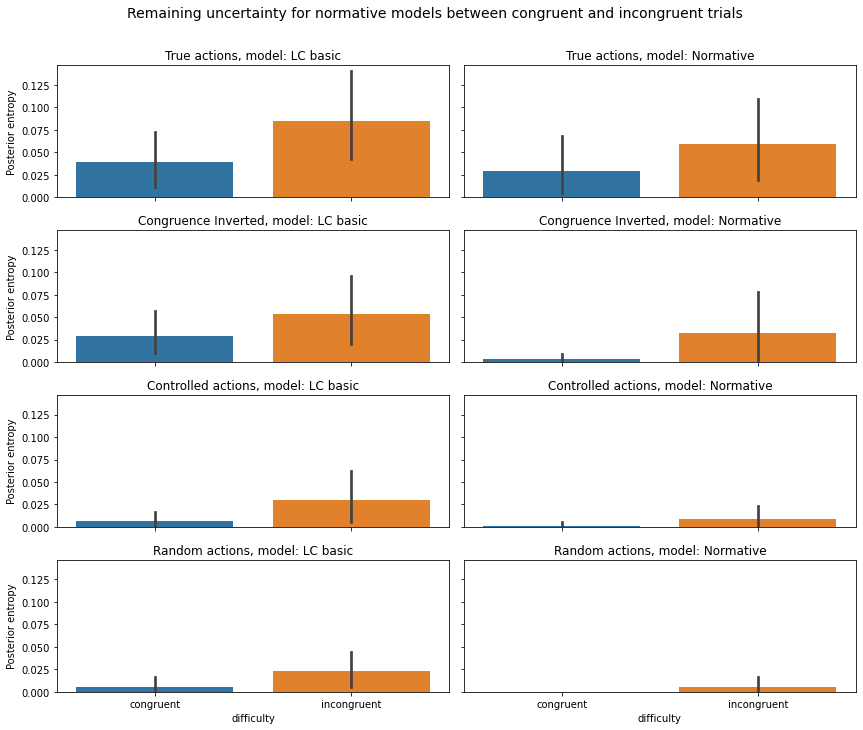

In [36]:
models = ['LC_discrete_&_1', 'normative_&_1']
model_labels = ['LC basic', 'Normative']

tags = ['TA', 'CI', 'SA', 'RA']
tags_label = ['True actions', 'Congruence Inverted', 'Controlled actions', 'Random actions']

x = 'difficulty'
y = 'posterior_entropy_unsmoothed'
y_label = 'Posterior Entropy'

summary_2 = summary[summary.experiment == 'experiment_3']
fig, axs = plt.subplots(len(tags), len(models), figsize=(12, 10), sharex=True, sharey=True)

for i, tag in enumerate(tags):
    df_tag = summary_2[summary_2.tag == tag]
    
    df_clean = df_tag[df_tag.difficulty.isin(['congruent', 'incongruent', 'implausible'])]

    for j, model in enumerate(models):
        
        df_plot = df_clean[df_clean.model_name == model]
        t, p = stats.ttest_rel(df_plot[df_plot.difficulty == 'incongruent'][y], df_plot[df_plot.difficulty == 'congruent'][y])
        print(f'{tag}, model: {model}, t={np.round(t, 5)}, p={np.round(p, 5)}')
        ratio = df_plot[df_plot.difficulty == 'incongruent'][y].mean() / df_plot[df_plot.difficulty == 'congruent'][y].mean()
        print(f'Entropy ratio between both condition: {ratio} \n')
        sns.barplot(x=x, y=y, data=df_plot, ax=axs[i, j])

        if j > 0:
            axs[i, j].set_ylabel('')
        else:
            axs[i, j].set_ylabel('Posterior entropy')

        if i < len(tags) - 1:
            axs[i, j].set_xlabel('')

        axs[i, j].set_title(f'{tags_label[i]}, model: {model_labels[j]}')


fig.suptitle('Remaining uncertainty for normative models between congruent and incongruent trials', fontsize=14, y=1.01)
plt.tight_layout()



In [ ]:
models = ['LC_discrete_&_1', 'normative_&_1']

tags = ['TA', 'SA', 'CA', 'RA']

x = 'difficulty'
y = 'posterior_entropy_unsmoothed'
y_label = 'Posterior Entropy'

summary_2 = summary[summary.experiment == 'experiment_3']
fig, axs = plt.subplots(len(tags), len(models), figsize=(20, 10), sharex=True, sharey=True)

for i, tag in enumerate(tags):
    df_tag = summary_2[summary_2.tag == tag]
    
    df_clean = df_tag[df_tag.difficulty.isin(['congruent', 'incongruent', 'implausible'])]

    for j, model in enumerate(models):
        #t, p = stats.ttest_ind()
        df_plot = df_clean[df_clean.model_name == model]
        sns.histplot(df_plot[df_plot.difficulty == 'incongruent'][y], ax=axs[i, j])

        if j > 0:
            axs[i, j].set_ylabel('')
        else:
            axs[i, j].set_ylabel('')

        if i < len(tags) - 1:
            axs[i, j].set_xlabel('')

        axs[i, j].set_title('')

plt.tight_layout()

KeyboardInterrupt: 

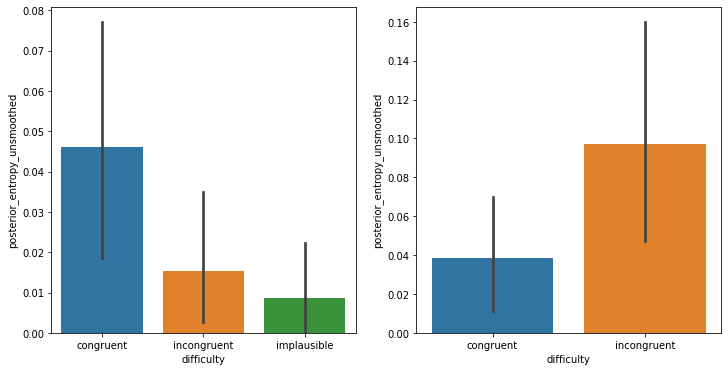

In [ ]:
x = 'difficulty'
y = 'posterior_entropy_unsmoothed'

experiments = ['experiment_2', 'experiment_3']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, experiment in enumerate(experiments):
    df_plot = df_norm_label[df_norm_label.experiment == experiment]
    sns.barplot(x=x, y=y, data=df_plot, ax=axs[i])


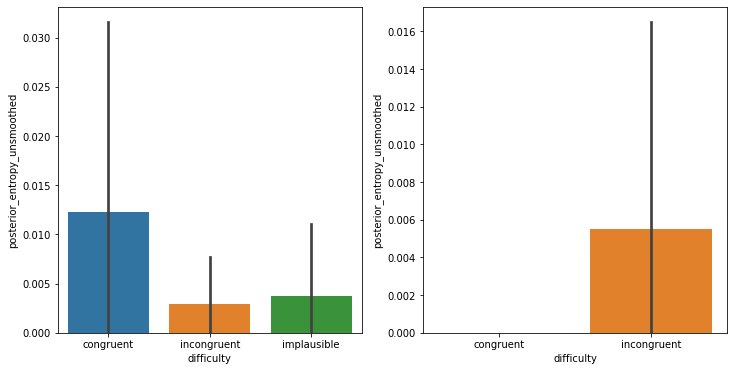

In [ ]:
summary = pd.read_csv('./data/model_fitting_outputs/summary_data_run_random.csv')
summary['information_gained'] = (summary['prior_entropy'] - summary['posterior_entropy']) / summary['prior_entropy']

df_norm = summary[summary.model_name == 'normative_&_1']

df_norm_label = df_norm[df_norm.difficulty.isin(['congruent', 'incongruent', 'implausible'])]

x = 'difficulty'
y = 'posterior_entropy_unsmoothed'

experiments = ['experiment_2', 'experiment_3']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, experiment in enumerate(experiments):
    df_plot = df_norm_label[df_norm_label.experiment == experiment]
    sns.barplot(x=x, y=y, data=df_plot, ax=axs[i])
